## Practical Work 4

For this practical work, the student will have to develop a Python program that is able to implement the accelerated gradient descent methods with adaptive learning rate <b>(Adagrad, RMSProp, and Adam)</b> in order to achieve the linear regression of a set of datapoints.

#### Import numpy, matplotlib.pyplot and make it inline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import enum

In [ ]:
%matplotlib inline

To have a dataset or set of data points, the student must generate a pair of arrays <b>X</b> and <b>y</b> with the values in <b>X</b> equally distributed between <b>0</b> and <b>20</b> and the values in <b>y</b> such that: 
<b>yi = a*xi + b (and a = -1, b = 2)</b>


In [ ]:
a = -1
b = 2
X = np.linspace(0, 20, 100)
y = a * X + b
X = X.reshape(-1, 1)

#### Plot your data points. 

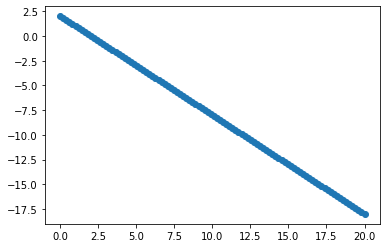

In [ ]:
plt.scatter(X, y)

### OptimzerType

In [ ]:
class OptimizerType(enum.Enum):
    GradientDescent = 0
    Momentum = 1
    NesterovAcceleratedGradient = 2
    Adagrad = 3
    RMSProp = 4
    Adam = 5

### Optimizer

In [ ]:
class Optimizer:
    def __init__(self, learning_rate=0.001, gamma_momentum=0.9, b1_momentum=0.9, b2_RMSProp=0.999, epsilon=1e-8,
                 optimizer_type=OptimizerType.GradientDescent):
        self.theta = None
        self.vt = None
        self.mt = None
        self.learning_rate = learning_rate
        self.gamma_momentum = gamma_momentum
        self.optimizer_type = optimizer_type
        self.b1_momentum = b1_momentum
        self.b2_RMSProp = b2_RMSProp
        self.epsilon = epsilon

    def init_weights(self, input_dim):
        self.theta = 0.1 * np.random.randn(input_dim + 1)
        self.vt = np.zeros(input_dim + 1)
        self.mt = np.zeros(input_dim + 1)

    def vectorize_features(self, X):
        return np.hstack((np.ones((X.shape[0], 1)), X))

    def mean_squared_error(self, y, yhat):
        m = y.shape[0]
        return 1 / (2 * m) * ((yhat - y) ** 2).sum()

    def mean_square_error_grad(self, X, y, A):
        return 1 / y.size * np.dot(X.T, (A - y))

    def forward(self, X, theta=None):
        if theta is not None:
            return np.dot(X, theta)
        return np.dot(X, self.theta.T)

    def backward(self, X_vec, y, A):
        dtheta = self.mean_square_error_grad(X_vec, y, A)
        return dtheta

    def get_momentum(self, dtheta):
        self.vt = self.vt * self.gamma_momentum + self.learning_rate * dtheta
        return self.theta - self.vt

    def get_nesterov_accelerated_gradient(self, X_vec, y):
        theta_temp = self.theta - self.gamma_momentum * self.vt
        theta_temp_grad = self.mean_square_error_grad(X_vec, y, self.forward(X_vec, theta_temp))
        next_theta = theta_temp - self.learning_rate * theta_temp_grad
        self.vt = self.gamma_momentum * self.vt + self.learning_rate * theta_temp_grad
        return next_theta

    def get_Adagrad(self, dtheta):
        self.vt = self.vt + (dtheta**2)
        adaptive_learning = self.learning_rate / np.sqrt(self.vt + self.epsilon)
        return self.theta - adaptive_learning * dtheta

    def get_RMSProp(self, dtheta):
        self.vt = self.b1_momentum * self.vt + (1-self.b1_momentum) * (dtheta**2)
        adaptive_learning = self.learning_rate / (np.sqrt(self.vt) + self.epsilon)
        return self.theta - adaptive_learning * dtheta

    def get_Adam(self, dtheta, iteration_num):
        self.mt = self.b1_momentum * self.mt + (1 - self.b1_momentum) * dtheta
        self.vt = self.b2_RMSProp * self.vt + (1 - self.b2_RMSProp) * (dtheta**2)
        self.mt = self.mt / (1.0 - self.b1_momentum ** (iteration_num+1))
        self.vt = self.vt / (1.0 - self.b2_RMSProp ** (iteration_num+1))
        adaptive_learning = self.learning_rate / (np.sqrt(self.vt) + self.epsilon)
        return self.theta - (adaptive_learning * self.mt)

    def update(self, X_vec, y, dtheta, iteration_num):
        if self.optimizer_type == OptimizerType.Momentum:
            return self.get_momentum(dtheta)

        elif self.optimizer_type == OptimizerType.NesterovAcceleratedGradient:
            return self.get_nesterov_accelerated_gradient(X_vec, y)

        elif self.optimizer_type == OptimizerType.Adagrad:
            return self.get_Adagrad(dtheta)

        elif self.optimizer_type == OptimizerType.RMSProp:
            return self.get_RMSProp(dtheta)

        elif self.optimizer_type == OptimizerType.Adam:
            return self.get_Adam(dtheta, iteration_num)

        else:
            return self.theta - self.learning_rate * dtheta

### Model

In [ ]:
class Model:
    def __init__(self):
        self.optimizer = None

    def normalize(self, X):
        return (X - X.mean()) / X.std()

    def mini_batch(self, X, y, batch_size, shuffle=False):
        assert X.shape[0] == y.shape[0]
        indices = range(X.shape[0])
        if shuffle:
            indices = np.random.permutation(X.shape[0])
        for start_idx in range(0, X.shape[0] - batch_size + 1, batch_size):
            if shuffle:
                excerpt = indices[start_idx:start_idx + batch_size]
            else:
                excerpt = slice(start_idx, start_idx + batch_size)
            yield X[excerpt], y[excerpt]

    def fit(self, X, y, optimizer, batch_size=1, epochs=20, shuffle=False, tolerance=1e-5):
        train_error_log = []
        train_theta_log = []
        optimizer.init_weights(X.shape[1])
        X = optimizer.vectorize_features(X)
        X = self.normalize(X)
        prev_dtheta = optimizer.theta
        dtheta = None

        for epoch in range(epochs):
            for X_batch, y_batch in self.mini_batch(X, y, batch_size=batch_size, shuffle=shuffle):
                A = optimizer.forward(X_batch)
                dtheta = optimizer.backward(X_batch, y_batch, A)
                optimizer.theta = optimizer.update(X_batch, y_batch, dtheta, epoch)

            if np.abs(np.linalg.norm(dtheta, 2) - np.linalg.norm(prev_dtheta, 2)) < tolerance:
                break
            prev_dtheta = optimizer.theta

            yhat = optimizer.forward(X)
            train_error_log.append(optimizer.mean_squared_error(yhat, y))
            train_theta_log.append(optimizer.theta)

        self.optimizer = optimizer
        return train_error_log, train_theta_log

    def predict(self, X, theta=None):
        X = self.optimizer.vectorize_features(X)
        X = self.normalize(X)
        return self.optimizer.forward(X, theta)

    def plot_loss_epoch(self, train_error_log):
        plt.plot(range(len(train_error_log)), train_error_log)
        plt.title('Loss Vs Epochs', fontSize=18)
        plt.xlabel('Epochs', fontSize=12)
        plt.ylabel('MSE', fontSize=12)
        plt.show()

    def plot_theata_epoch(self, train_error_log, theta, theta_index):
        theta = np.array(theta)
        plt.plot(train_error_log, theta[:, theta_index])
        plt.title('Theta' + str(theta_index) + ' Vs Epochs', fontSize=18)
        plt.xlabel('MSE', fontSize=12)
        plt.ylabel('Theta' + str(theta_index), fontSize=12)
        plt.show()

    def plot_all_boundaries(self, X, y, train_theta_log):
        plt.scatter(X, y, c="blue", label='Points')
        for index in range(0, len(train_theta_log)):
            yhat = self.predict(X, train_theta_log[index])
            plt.plot(X, yhat, c='orange')

        yhat = self.predict(X, train_theta_log[-1])
        plt.plot(X, yhat, c='red', label='Final line boundary')
        plt.xlabel('X', fontSize=12)
        plt.ylabel('y', fontSize=12)
        plt.show()

    def plot_final_boundary(self, X, y):
        plt.figure(figsize=(20, 20))
        plt.scatter(X, y, c="blue", label='Points')
        yhat = self.predict(X)
        plt.plot(X, yhat, c='red', label='Final line boundary')
        plt.xlabel('X', fontSize=12)
        plt.ylabel('y', fontSize=12)
        plt.show()

    def print_r2_score(self, y, yhat):
        print("r2_score: ")
        print(r2_score(y, yhat))

    def check_builtin(self, X, y):
        clf = LinearRegression()
        clf.fit(X, y)
        yhat = clf.predict(X)
        print("sklearn.LinearRegression :")
        self.print_r2_score(y, yhat)

### Tuning

In [ ]:
import random
from sklearn.metrics import r2_score


class Tuning:
    def __init__(self, X, y, optimizer_type, hyper_params_dict):
        self.hyper_params_dict = hyper_params_dict
        self.optimizer_type = optimizer_type
        self.X = X
        self.y = y
        self.model_log = []

    def run_experiments(self, num_exp):
        for _ in range(num_exp):
            opt_learning_rate = 0.5
            opt_gamma_momentum = 0.9
            opt_b1_momentum = 0.9
            opt_b2_RMSProp = 0.9
            opt_epsilon = 1e-8
            mdl_epochs = 200
            mdl_shuffle = True
            mdl_batch_size = 5

            if "opt_learning_rate" in self.hyper_params_dict.keys():
                if len(self.hyper_params_dict["opt_learning_rate"]) != 0:
                    opt_learning_rate = random.choice(self.hyper_params_dict["opt_learning_rate"])

            if "opt_gamma_momentum" in self.hyper_params_dict.keys():
                if len(self.hyper_params_dict["opt_gamma_momentum"]) != 0:
                    opt_gamma_momentum = random.choice(self.hyper_params_dict["opt_gamma_momentum"])

            if "opt_b1_momentum" in self.hyper_params_dict.keys():
                if len(self.hyper_params_dict["opt_b1_momentum"]) != 0:
                    opt_b1_momentum = random.choice(self.hyper_params_dict["opt_b1_momentum"])

            if "opt_b2_RMSProp" in self.hyper_params_dict.keys():
                if len(self.hyper_params_dict["opt_b2_RMSProp"]) != 0:
                    opt_b2_RMSProp = random.choice(self.hyper_params_dict["opt_b2_RMSProp"])

            if "opt_epsilon" in self.hyper_params_dict.keys():
                if len(self.hyper_params_dict["opt_epsilon"]) != 0:
                    opt_epsilon = random.choice(self.hyper_params_dict["opt_epsilon"])

            if "mdl_epochs" in self.hyper_params_dict.keys():
                if len(self.hyper_params_dict["mdl_epochs"]) != 0:
                    mdl_epochs = random.choice(self.hyper_params_dict["mdl_epochs"])

            if "mdl_shuffle" in self.hyper_params_dict.keys():
                if len(self.hyper_params_dict["mdl_shuffle"]) != 0:
                    mdl_shuffle = random.choice(self.hyper_params_dict["mdl_shuffle"])

            if "mdl_batch_size" in self.hyper_params_dict.keys():
                if len(self.hyper_params_dict["mdl_batch_size"]) != 0:
                    mdl_batch_size = random.choice(self.hyper_params_dict["mdl_batch_size"])

            optimizer = Optimizer(learning_rate=opt_learning_rate,
                                  gamma_momentum=opt_gamma_momentum,
                                  b1_momentum=opt_b1_momentum,
                                  b2_RMSProp=opt_b2_RMSProp,
                                  epsilon=opt_epsilon,
                                  optimizer_type=self.optimizer_type)
            model = Model()
            train_error_log, train_theta_log = model.fit(self.X, self.y, optimizer, mdl_batch_size, mdl_epochs,
                                                         mdl_shuffle)
            yhat = model.predict(self.X)
            r2_score_value = r2_score(self.y, yhat)
            self.model_log.append({
                    "model_optimizer": str(self.optimizer_type),
                    "opt_learning_rate": opt_learning_rate,
                    "opt_gamma_momentum": opt_gamma_momentum,
                    "opt_b1_momentum": opt_b1_momentum,
                    "opt_b2_RMSProp": opt_b2_RMSProp,
                    "opt_epsilon": opt_epsilon,
                    "mdl_epochs": mdl_epochs,
                    "mdl_shuffle": mdl_shuffle,
                    "mdl_batch_size": mdl_batch_size,
                    "r2_score": r2_score_value,
                    #"train_error_log": train_error_log,
                    #"train_theta_log": train_theta_log,
                })
        return self.model_log


## Adagrad

### For a single variable linear regression ML model, build a function to find the optimum Theta_0 and Theta_1 parameters using Adagrad optimization algorithm.
#### The funtion should have the following input parameters:
##### 1. Input data as a matrix (or vector based on your data).
##### 2. Target label as a vector.
##### 3. Learning rate.
##### 4. Epsilon.
##### 5. Maximum number of iterations (Epochs).
#### The funtion should return the following outputs:
##### 1. All predicted Theta_0 in all iterations.
##### 2. All predicted Theta_1 in all iterations.
##### 3. Corresponding loss for each Theta_0 and Theta_1 predictions.
##### 4.All hypothesis outputs (prdicted labels) for each Theta_0 and Theta_1 predictions.
##### 5.Final Optimum values of Theta_0 and Theta_1.
#### Choose the suitable number of iterations, learning rate, Epsilon, and stop criteria.
#### Calculate r2 score. Shouldn't below 0.9
#### Plot the required curves (loss-epochs, loss-theta0, loss-theta1, all fitted lines per epoch (single graph), best fit line)
#### Try different values of the huperparameters and see the differnce in your results.

![image.png](attachment:image.png)

In [ ]:
class Optimizer_Adagrad(Optimizer):
    
    def get_Adagrad(self, dtheta):
        self.vt = self.vt + (dtheta**2)
        adaptive_learning = self.learning_rate / np.sqrt(self.vt + self.epsilon)
        return self.theta - adaptive_learning * dtheta
    
    def update(self, X_vec, y, dtheta, iteration_num):
        return self.get_Adagrad(dtheta)       

In [ ]:
learning_rate = 0.5
optimizer = Optimizer_Adagrad(learning_rate=learning_rate, optimizer_type=OptimizerType.Adagrad)
epochs = 200
shuffle = True
batch_size = X.shape[0]
model = Model()
train_error_log, train_theta_log = model.fit(X, y, optimizer, batch_size, epochs, shuffle)

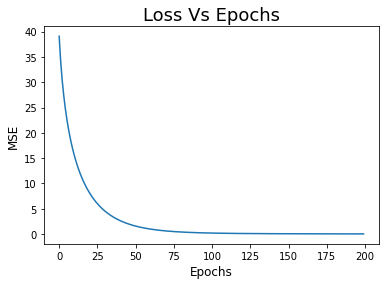

In [ ]:
model.plot_loss_epoch(train_error_log)

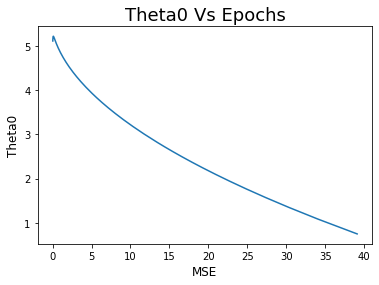

In [ ]:
model.plot_theata_epoch(train_error_log, train_theta_log, 0)

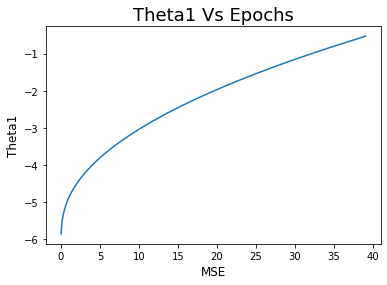

In [ ]:
model.plot_theata_epoch(train_error_log, train_theta_log, 1)

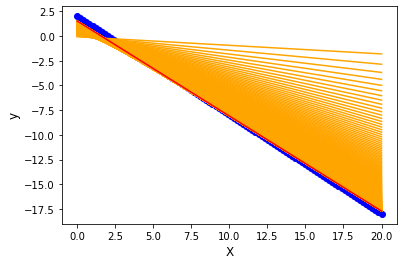

In [ ]:
model.plot_all_boundaries(X, y, train_theta_log)

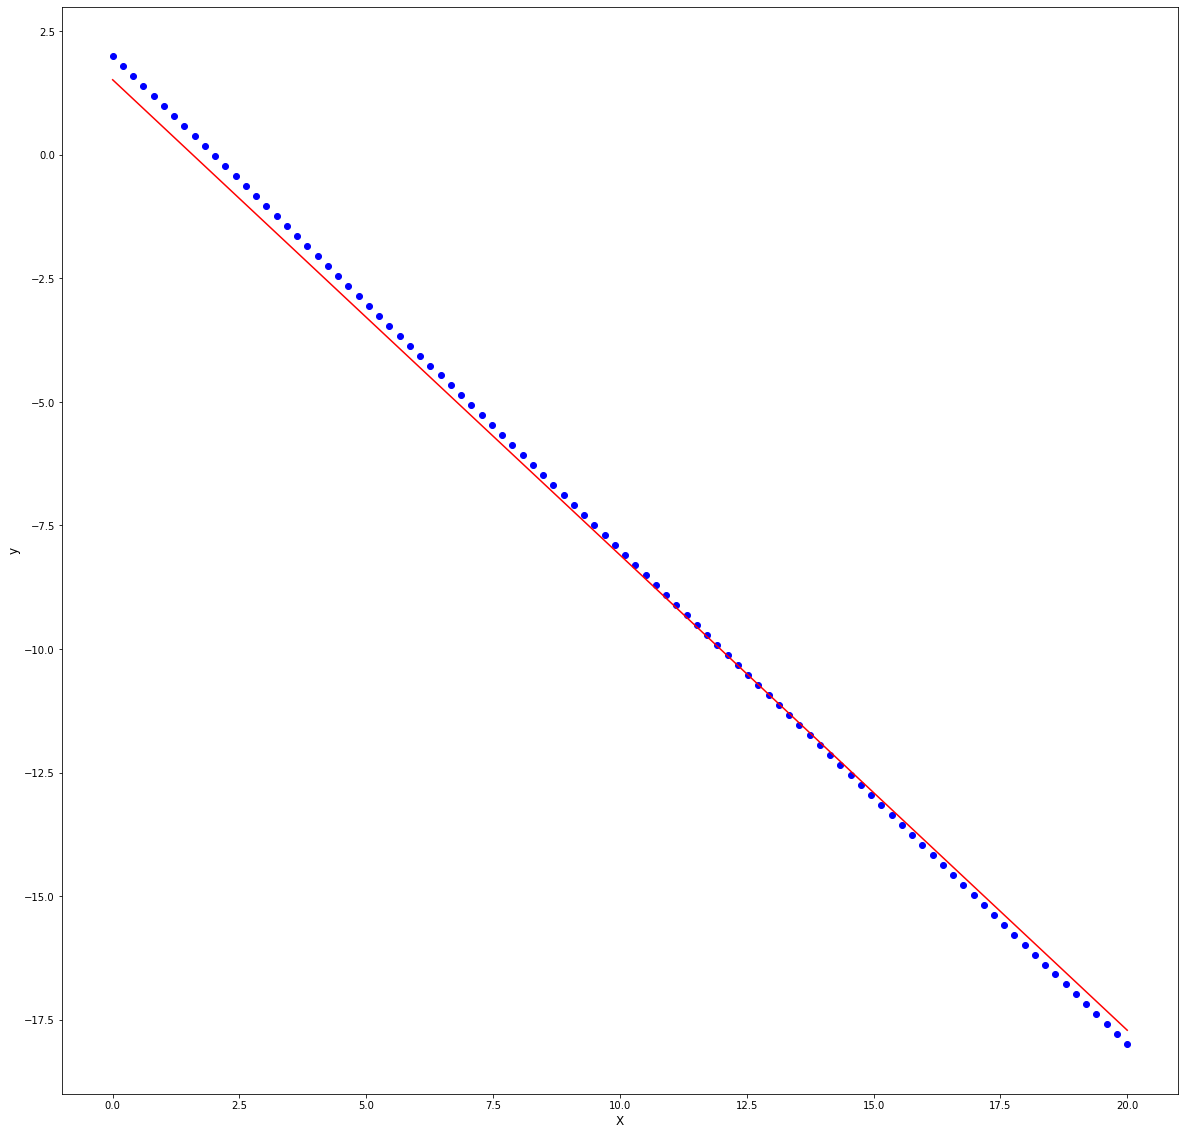

In [ ]:
model.plot_final_boundary(X, y)

In [ ]:
yhat = model.predict(X)

In [ ]:
model.print_r2_score(y, yhat)

r2_score: 
0.9982502304388003


## RMSProp

### Update the previos implementation to be RMSProp.
#### Compare your results with Adagrad results.

![image.png](attachment:image.png)

In [ ]:
class Optimizer_RMSProp(Optimizer):
    def get_RMSProp(self, dtheta):
        self.vt = self.b1_momentum * self.vt + (1-self.b1_momentum) * (dtheta**2)
        adaptive_learning = self.learning_rate / (np.sqrt(self.vt) + self.epsilon)
        return self.theta - adaptive_learning * dtheta

    def update(self, X_vec, y, dtheta, iteration_num):       
        return self.get_RMSProp(dtheta)

In [ ]:
learning_rate = 0.5
b1_momentum = 0.9
optimizer = Optimizer_RMSProp(learning_rate=learning_rate, b1_momentum=b1_momentum, optimizer_type=OptimizerType.RMSProp)
epochs = 200
shuffle = True
batch_size = X.shape[0]
model = Model()
train_error_log, train_theta_log = model.fit(X, y, optimizer, batch_size, epochs, shuffle)

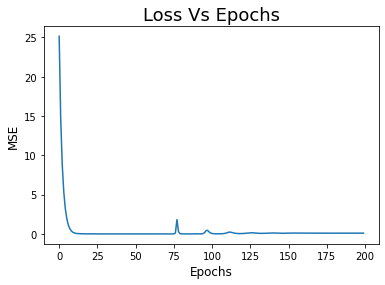

In [ ]:
model.plot_loss_epoch(train_error_log)

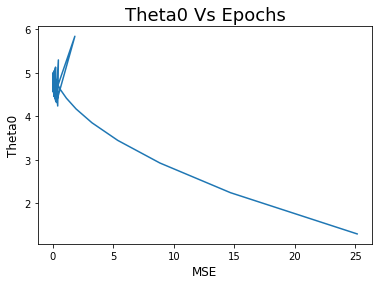

In [ ]:
model.plot_theata_epoch(train_error_log, train_theta_log, 0)

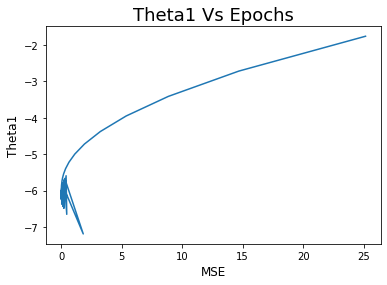

In [ ]:
model.plot_theata_epoch(train_error_log, train_theta_log, 1)

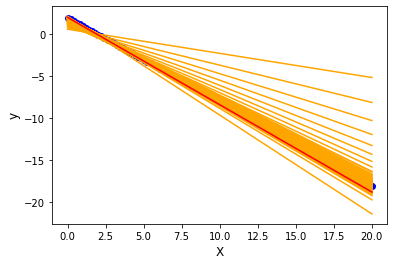

In [ ]:
model.plot_all_boundaries(X, y, train_theta_log)

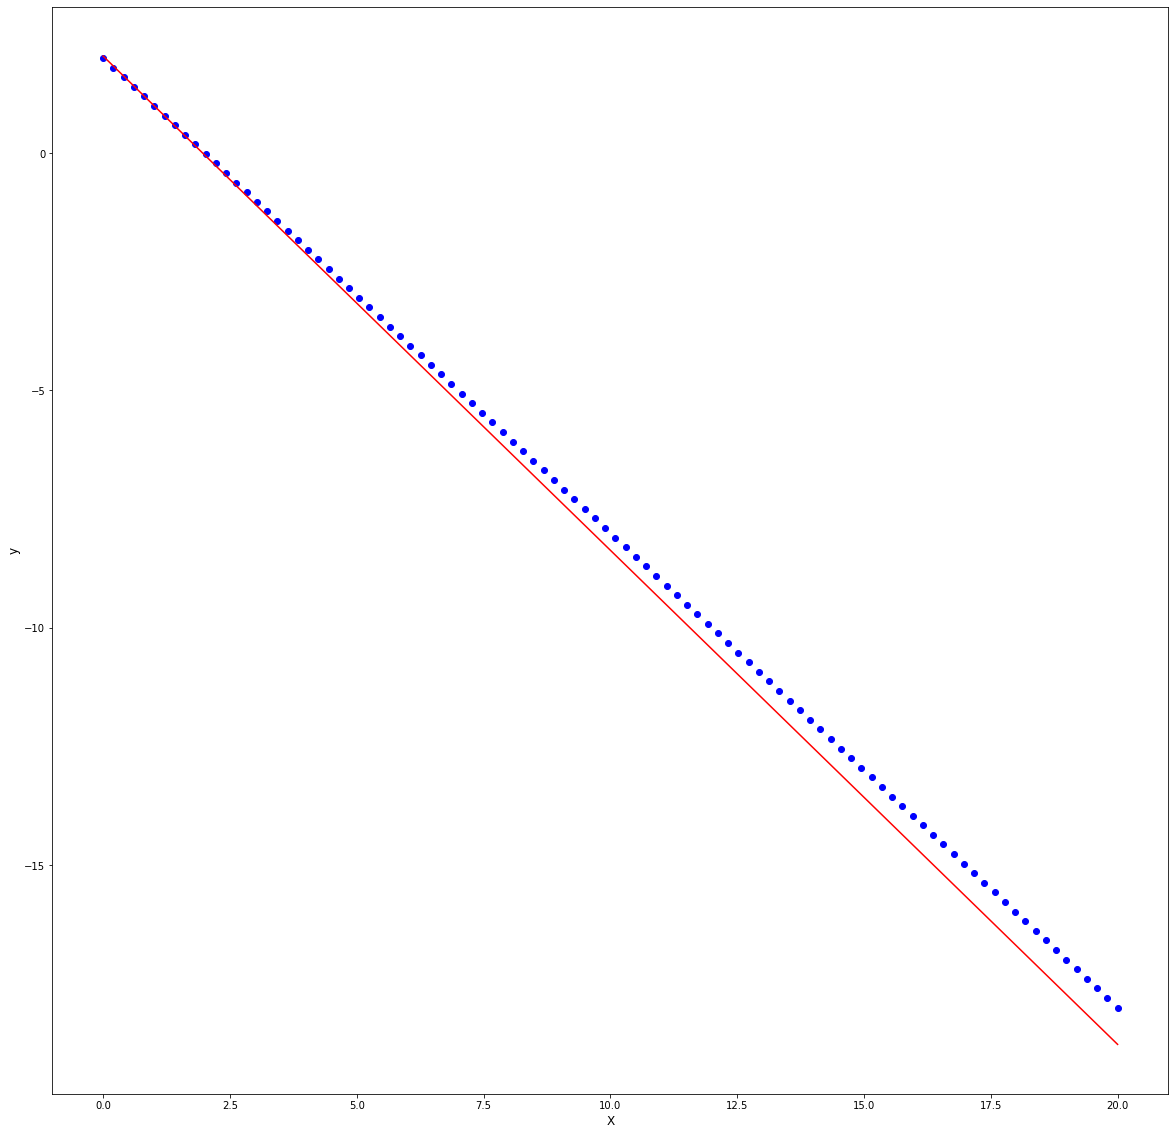

In [ ]:
model.plot_final_boundary(X, y)

In [ ]:
yhat = model.predict(X)

In [ ]:
model.print_r2_score(y, yhat)

r2_score: 
0.9943669344462512


## Adam

### Update the previos implementation to be Adam.
#### Compare your results with Adagrad and RMSProp results.

![image-4.png](attachment:image-4.png)

In [ ]:
class Optimizer_Adam(Optimizer):
    def get_Adam(self, dtheta, iteration_num):
        self.mt = self.b1_momentum * self.mt + (1 - self.b1_momentum) * dtheta
        self.vt = self.b2_RMSProp * self.vt + (1 - self.b2_RMSProp) * (dtheta**2)
        self.mt = self.mt / (1.0 - self.b1_momentum ** (iteration_num+1))
        self.vt = self.vt / (1.0 - self.b2_RMSProp ** (iteration_num+1))
        adaptive_learning = self.learning_rate / (np.sqrt(self.vt) + self.epsilon)
        return self.theta - (adaptive_learning * self.mt)

    def update(self, X_vec, y, dtheta, iteration_num):        
        return self.get_Adam(dtheta, iteration_num)

In [ ]:
learning_rate = 0.5
b1_momentum = 0.8
b2_RMSProp = 0.8
optimizer = Optimizer_Adam(learning_rate=learning_rate, b1_momentum=b1_momentum, b2_RMSProp=b2_RMSProp, 
                           optimizer_type=OptimizerType.Adam)
epochs = 500
shuffle = True
batch_size = X.shape[0]
model = Model()
train_error_log, train_theta_log = model.fit(X, y, optimizer, batch_size, epochs, shuffle)

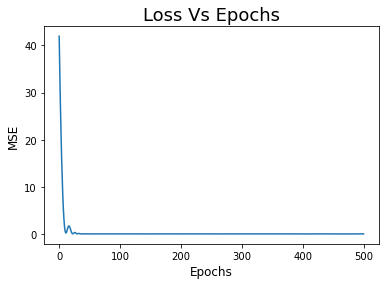

In [ ]:
model.plot_loss_epoch(train_error_log)

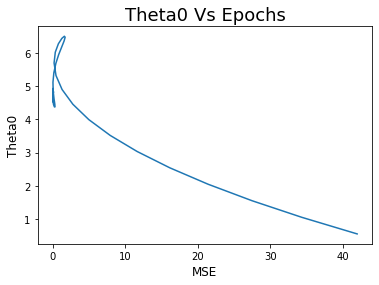

In [ ]:
model.plot_theata_epoch(train_error_log, train_theta_log, 0)

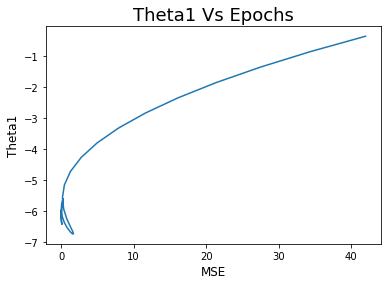

In [ ]:
model.plot_theata_epoch(train_error_log, train_theta_log, 1)

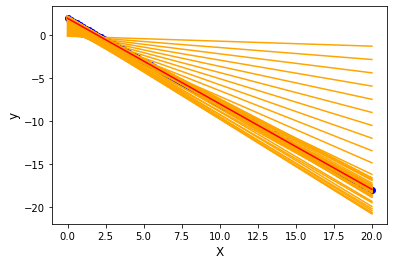

In [ ]:
model.plot_all_boundaries(X, y, train_theta_log)

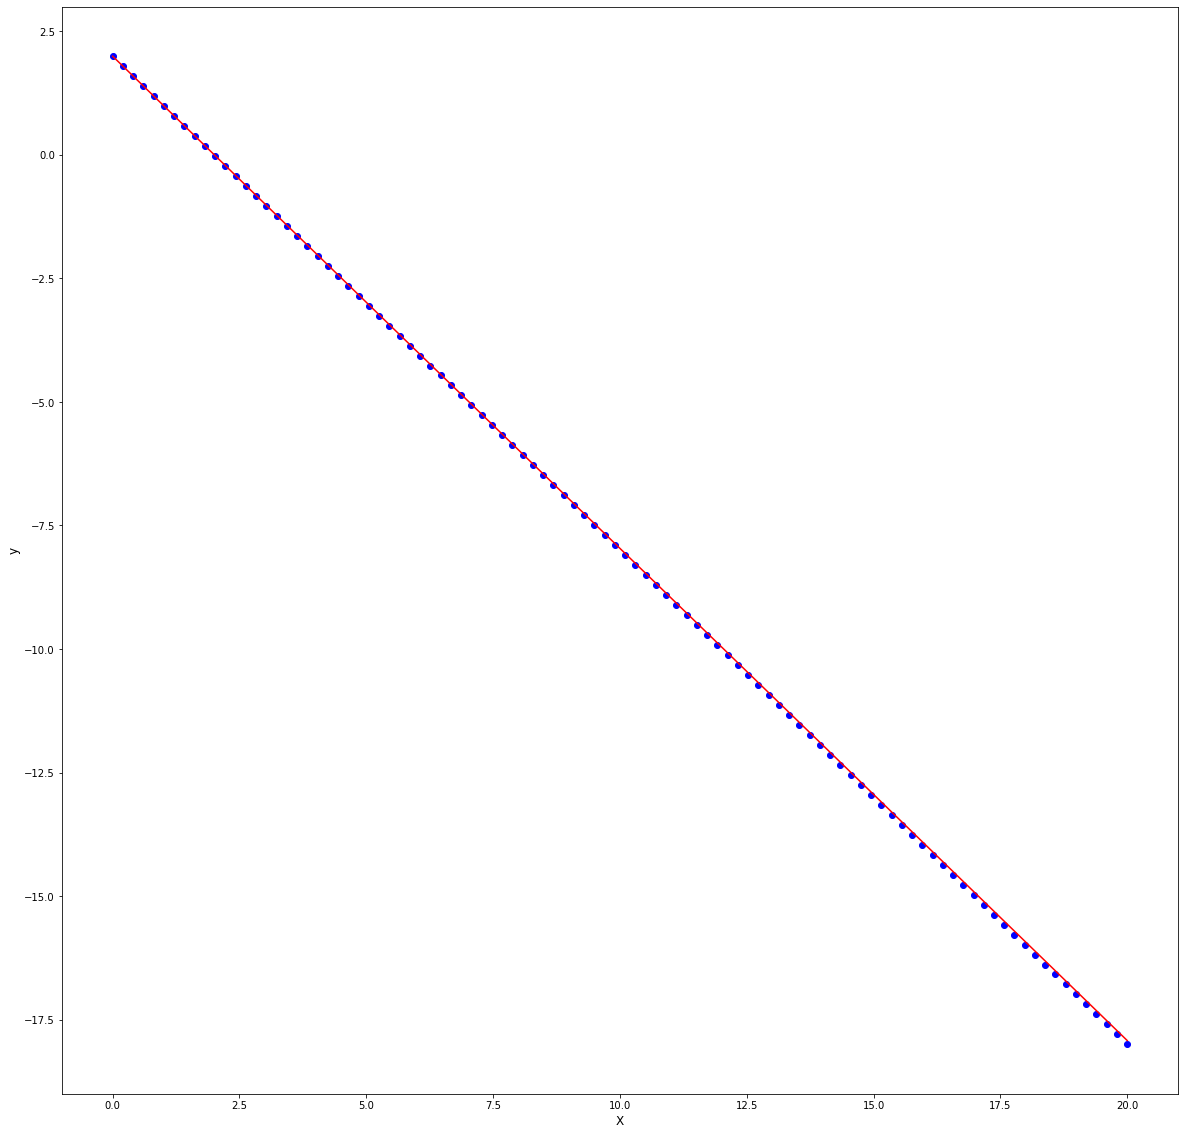

In [ ]:
model.plot_final_boundary(X, y)

In [ ]:
yhat = model.predict(X)

In [ ]:
model.print_r2_score(y, yhat)

r2_score: 
0.9999434630950148


### With Hyperparameters Tuning

In [ ]:
hyper_params_dict = {
    "opt_learning_rate": [0.5, 0.4],
    "opt_gamma_momentum": [0.8, 0.8],
    "opt_b1_momentum": [0.8, 0.7],
    "opt_b2_RMSProp": [0.8, 0.7],
    "opt_epsilon": [1e-8, 1e-7],
    "mdl_epochs": [300, 500],
    "mdl_shuffle": [True, False],
    "mdl_batch_size": [X.shape[0], 5]
}
tun = Tuning(X, y, OptimizerType.Adam, hyper_params_dict)
model_log = tun.run_experiments(5)

In [ ]:
print(model_log)

[{'model_optimizer': 'OptimizerType.Adam', 'opt_learning_rate': 0.4, 'opt_gamma_momentum': 0.8, 'opt_b1_momentum': 0.7, 'opt_b2_RMSProp': 0.7, 'opt_epsilon': 1e-08, 'mdl_epochs': 500, 'mdl_shuffle': False, 'mdl_batch_size': 5, 'r2_score': -2096400222.3272462}, {'model_optimizer': 'OptimizerType.Adam', 'opt_learning_rate': 0.4, 'opt_gamma_momentum': 0.8, 'opt_b1_momentum': 0.7, 'opt_b2_RMSProp': 0.8, 'opt_epsilon': 1e-08, 'mdl_epochs': 300, 'mdl_shuffle': True, 'mdl_batch_size': 5, 'r2_score': 0.999930023205949}, {'model_optimizer': 'OptimizerType.Adam', 'opt_learning_rate': 0.5, 'opt_gamma_momentum': 0.8, 'opt_b1_momentum': 0.7, 'opt_b2_RMSProp': 0.8, 'opt_epsilon': 1e-08, 'mdl_epochs': 300, 'mdl_shuffle': True, 'mdl_batch_size': 100, 'r2_score': 0.9996610148247829}, {'model_optimizer': 'OptimizerType.Adam', 'opt_learning_rate': 0.5, 'opt_gamma_momentum': 0.8, 'opt_b1_momentum': 0.7, 'opt_b2_RMSProp': 0.7, 'opt_epsilon': 1e-08, 'mdl_epochs': 500, 'mdl_shuffle': True, 'mdl_batch_size': 

## Congratulations 
![image.png](attachment:image.png)